# Tarea 06

## Entrega: Miércoles 7 de octubre de 2015

[1] [Puedes brincar directo a la parte (iv).]

(i) Escribe una versión de Euler que funcione para un número arbitrario de variables. Acepta una función $\mathbf{f}: \mathbb{R}^n \to \mathbb{R}^n$, es decir, una función que come un vector y escupe otro. La estructura debe consistir en una función que actualiza las variables en un solo paso, y otra que integra desde un tiempo inicial hasta un tiempo final y regresa la trayectoria.

(ii) Escribe una versión de Runge-Kutta de segundo orden que funcione para un número arbitrario de variables, con la misma estructura.

(iii) Escribe una versión de Runge-Kutta de cuarto orden que funcione para un número arbitrario de variables, con la misma estructura.

(iv) Observando la similitud alta de las funciones que has hecho, has una función `integrar`, en el cual especifiques un parámetro adicional, `metodo`, que escoge el método (Euler, RK2 o RK4) para cada paso.

In [7]:
### Solución
# La función f aceptará argumentos de la forma {x, t}, donde x es un vector arbitrario, y regresará un vector de la 
# misma dimensión tal que x'(t) = f(x(t), t).

# Además, cualquiera de las funciones individuales relacionadas a los métodos de integración aceptará una celda
# de la forma {x_n, t_n}, donde x_n es un vector de por sí. Después, lo modificará en su lugar para no tener que pasar
# valores.

function euler_update!(values, f, h)
    values[1] += h*f(values) # Modificamos el vector
    values[2] += h # Movemos el tiempo
end;

function rk2_update!(values, f, h)
    k1 = f(values)
    k2 = f({values[1] + h * k1/2, values[2] + h/2})
    
    # Actualizamos el vector de estado
    values[1] += h*k2;
    values[2] += h;
end;

function rk4_update!(values, f, h)
    k1 = f(values)
    k2 = f({values[1] + h * k1 / 2, values[2] + h/2})
    k3 = f({values[1] + h * k2 / 2, values[2] + h/2})
    k4 = f({values[1] + h * k3, values[2] + h})
    
    # Actualizamos el vector de estado
    values[1] += h/6 * (k1 + 2*k2 + 2*k3 + k4);
    values[2] += h;
end;

# La función acepta las condiciones iniciales, el incremento de tiempo, el tiempo final,
# la función de evolución y el método a usar. Regresa la trayectoria del sistema en forma {t_values, x_values}
# que son los valores de x a cada tiempo t
function integrar(cond_iniciales, h, t_final, f, metodo=rk4_update!)
    estado = deepcopy(cond_iniciales) # Inicializamos el estado
    
    t_values = [estado[2]]
    x_values = estado[1]
    
    while estado[2] < t_final # Iteramos hasta llegar al final
        metodo(estado, f, h);
        
        # Agregamos un punto a la trayectoria
        t_values = vcat(t_values, estado[2])
        x_values = vcat(x_values, estado[1])
    end
    
    return {t_values, x_values};
end

integrar (generic function with 2 methods)

[2] 

(i) Considera el tiro parabólico (sin fricción). Escribe con cuidado las ecuaciones diferenciales, identificando las variables. Escribe la función $\mathbf{f}$ correspondiente en Julia, que acepta los valores de las variables y regresa las derivadas corresopndientes.

**Solución**

Un tiro parabólico bidimensional con gravedad apuntando hacia abajo se describe por el siguiente sistema de ecuaciones

$$
\begin{aligned}
x'(t) &= v_x(t) \\
v_x'(t) &= 0 \\
y'(t) &= v_y(t) \\
v_y'(t) &= -g \\
\end{aligned}
$$

Entonces, la función de evolución $f$ se escribirá como:

$$
f((x, v_x, y, v_y), t) = (v_x, 0, v_y, -g)
$$

En código:

In [3]:
# Función de evolución para un tiro parabólico sin fricción
# x es el vector de estado {(x, vx, y, vy), t}
function f_parabolic(estado)
    g = 9.8
    
    x = estado[1][1]
    vx = estado[1][2]
    y = estado[1][3]
    vy = estado[1][4]
    t = estado[2]
    
    return [vx 0 vy -g]
end

f_parabolic (generic function with 1 method)

(ii) Utiliza tus funciones para resolver numéricamente las ecuaciones del tiro parabólico (sin fricción) y compara con la solución analítica, con los tres métodos.

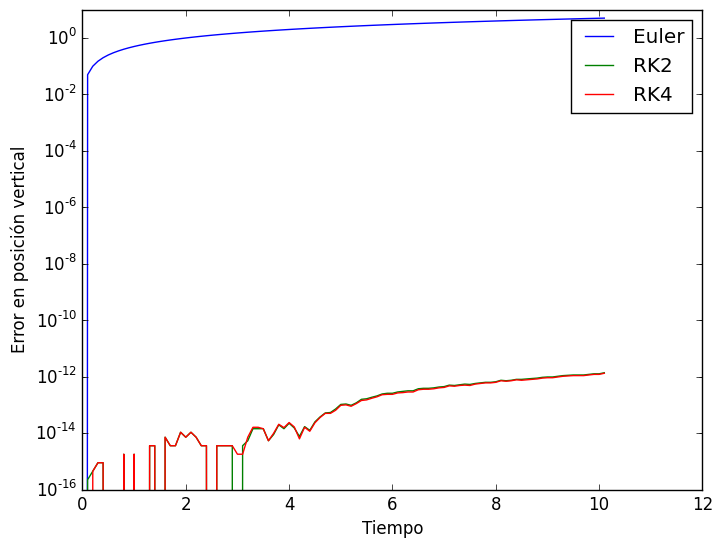

PyObject <matplotlib.text.Text object at 0x7f1ea7bed128>

In [19]:
using PyPlot;

# Por simplicidad, consideraremos la posición vertical con respecto al tiempo
x0 = 0
v0x = 10
y0 = 0
v0y = 20
iniciales = {[x0 v0x y0 v0y], 0}

# Esta es la función analítica exacta para y en función de t
function parabolic_analytic_y(t)
    g = 9.8
    
    return -g*t^2 / 2 + v0y*t + y0
end

solución_euler = integrar(iniciales, 0.1, 10, f_parabolic, euler_update!)
solución_rk2 = integrar(iniciales, 0.1, 10, f_parabolic, rk2_update!)
solución_rk4 = integrar(iniciales, 0.1, 10, f_parabolic, rk4_update!)

plot(solución_euler[1], abs(float([parabolic_analytic_y(t) for t in solución_euler[1]] - solución_euler[2][:,3])), label="Euler")
plot(solución_rk2[1], abs(float([parabolic_analytic_y(t) for t in solución_rk2[1]] - solución_rk2[2][:,3])), label="RK2")
plot(solución_rk4[1], abs(float([parabolic_analytic_y(t) for t in solución_rk4[1]] - solución_rk4[2][:,3])), label="RK4")

yscale("log")
legend()
xlabel("Tiempo")
ylabel("Error en posición vertical")

(iii) ¿Cómo varía la energía total en el tiempo con cada uno de los métodos? Según la dinámica clásica, ¿cómo debe variar? ¿Qué concluyes?

**Solución**

La energía en este caso se tiene que conservar. La energía total está dada por:

$$
E_T = \frac{mv^2}{2} + mgy = m \left( \frac{v_x^2}{2} + \frac{v_y^2}{2} + gy \right)
$$

Podemos ignorar la $m$ por simplicidad. Entonces, si aplicamos la función que calcula la energía a las trayectorias que obtuvimos, obtenemos:

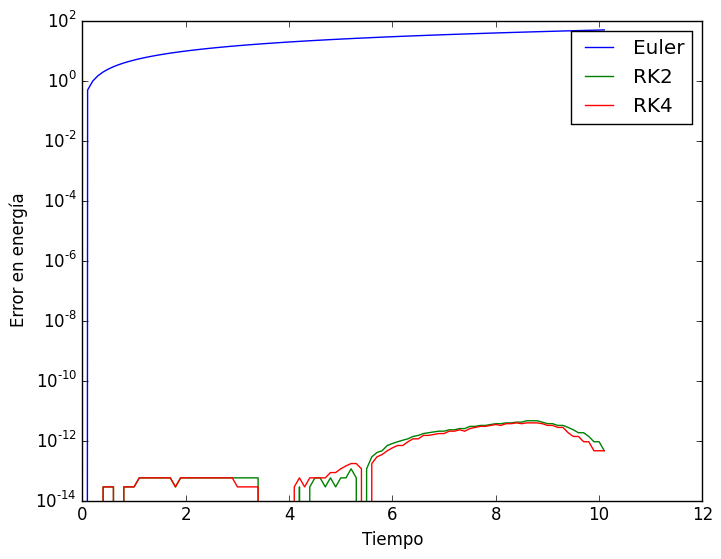

PyObject <matplotlib.text.Text object at 0x7f1ec609ca90>

In [33]:
# Función de energía que acepta el vector de estado
function energia_total(estado)
    g = 9.8
    vx = estado[2]
    y = estado[3]
    vy = estado[4]
    
    return vx^2/2 + vy^2/2 + g*y
end

energia_inicial = energia_total(iniciales[1])

# Y calculamos la energía para los tres casos
plot(solución_euler[1], abs(float([energia_inicial - energia_total(solución_euler[2][i,:]) for i in 1:size(solución_euler[1], 1)])), label="Euler")
plot(solución_rk2[1], abs(float([energia_inicial - energia_total(solución_rk2[2][i,:]) for i in 1:size(solución_rk2[1], 1)])), label="RK2")
plot(solución_rk4[1], abs(float([energia_inicial - energia_total(solución_rk4[2][i,:]) for i in 1:size(solución_rk4[1], 1)])), label="RK4")

yscale("log")
legend()
xlabel("Tiempo")
ylabel("Error en energía")

**Conclusión:**

El método de Euler no conserva la energía, mientras que RK2 y RK4 sí.

[3] 

(i) Agrega fricción proporcional a la *velocidad*. Identifica las variables necesarias y escribe las EDOs.

**Solución:**

En este caso, las ecuaciones (en forma vectorial) se vuelven

$$
\begin{aligned}
\vec{x}' &= \vec{v} \\
\vec{v}' &= -\alpha \vec{v} + \vec{g}
\end{aligned}
$$
donde $\alpha$ es un coeficiente arbitrario constante (coeficiente de fricción). Por lo tanto, la función $f$ se escribirá como:

$$
f(\vec{x}, \vec{v}, t) = (\vec{v}, -\alpha \vec{v} + \vec{g})
$$

En código:

In [55]:
# Esta función acepta una celda de estado {[x y vx vy], t}
function f_parabolic_linear_friction(state, α=1)
    g = [0 -9.8]
    x = state[1][:, 1:2]
    v = state[1][:, 3:4]
    
    return hcat(v, -α*v + g)
end

f_parabolic_linear_friction (generic function with 2 methods)

(ii) Escribe una versión diferente de Runge-Kutta que acepta otra función, que a su vez acepta el valores actual del vector de las variables. Esta función devolverá un valor booleano, que indica si cierta condición se satisface o no en base al vector de variables.

In [39]:
### Solución

# Esta función acepta una función de corte que se aplica al estado actual. Cuando esta función regresa false,
# la simulación se detiene.
function integrar_corte(cond_iniciales, h, funcion_corte::Function, f, metodo=rk4_update!)
    estado = deepcopy(cond_iniciales) # Inicializamos el estado
    
    t_values = [estado[2]]
    x_values = estado[1]
    
    while funcion_corte(estado) # Iteramos hasta llegar al final
        metodo(estado, f, h);
        
        # Agregamos un punto a la trayectoria
        t_values = vcat(t_values, estado[2])
        x_values = vcat(x_values, estado[1])
    end
    
    return {t_values, x_values};
end

integrar_corte (generic function with 4 methods)

(iii) Escribe una función que dice si la posición actual haya llegado de regreso a la tierra. Empezando desde alguna altura sobre la tierra, corre el tiro no-parabólico (es decir, con fricción) *hasta que* llegue de regreso a la tierra.

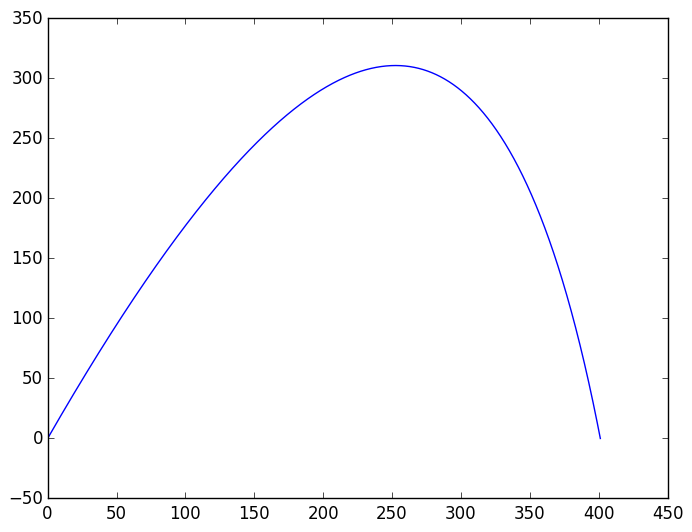

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1ea75ef940>

In [60]:
### Solución
# El proyectil llega a la tierra cuando su posición vertical es menor o igual a 0 Y cuando su 
# velocidad vertical es negativa

function tierra(state)
    y = state[1][2]
    vy = state[1][4]
    
    return !((y <= 0) && (vy <= 0))
end

iniciales_con_fricción = {[0 0 50 100], 0}
fr_sol = integrar_corte(iniciales_con_fricción, 0.01, tierra, s -> f_parabolic_linear_friction(s, 0.1))

plot(fr_sol[2][:,1], fr_sol[2][:,2])

(iv) Haz interactivo tu simulación, para poder cambiar los distintos parámetros.

(v) Dibuja el tiempo de vuelo y el alcance de la partícula en función del ángulo inicial para distintos tamaños de fricción.

(vi) ¿Cómo cambian los resultados si la fricción es proporcional al cuadrado de la *rapidez*?
[Pista: la fuerza de fricción siempre debe ser un *vector*. ¿En qué dirección apunta?] 